### Minimum Spinning Trees

MTS를 이용한 금융시장 분석

In [1]:
from collections import Counter
import itertools

import scipy
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import squareform
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import yfinance as yf

In [2]:
from mst import MinimumSpanningTree

def compute_log_returns(prices):
    log_returns = np.log(prices/prices.shift(1))[1:]
    return log_returns

def convert_to_distance_matrix(correlation_matrix):
    distance_matrix = np.sqrt(2*(1-correlation_matrix))
    return distance_matrix

def get_condensed_distance_matrix(matrix):
    x_indices, y_indices = np.triu_indices_from(matrix, k=1)
    condensed_distance = matrix[x_indices.tolist(), y_indices.tolist()]
    return condensed_distance

def build_graph(vertices, edges):
    graph = nx.Graph()
    graph.add_nodes_from(vertices)
    for edge in edges:
        weight, vertex_1, vertex_2 = edge
        graph.add_edge(vertex_1, vertex_2, weight=round(weight, 4))
    return graph

def draw_graph(graph, color_index, cmap, label=True):
    pos = nx.spring_layout(graph)
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_edges(graph, pos, width=1)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_family='sans-serif')
    labels = nx.get_edge_attributes(graph, 'weight')
    if label:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    nx.draw(graph, pos, node_color=color_index, cmap=cmap, node_size=700, alpha=0.5)
    plt.show()


#### Loading Price Data

sample data를 이용해서 살펴보도록 한다

In [3]:
prices_df = pd.read_csv("sp50_1year.csv", index_col=0)
tickers = list(prices_df)

In [5]:
ticker_info_df = pd.read_csv("selected_tickers_info.csv")
ticker_info_df

,Symbol,Name,Sector
0,ARE,Alexandria Real Estate Equities Inc,Real Estate
1,ALLE,Allegion,Industrials
2,AGN,"Allergan, Plc",Health Care
3,ALL,Allstate Corp,Financials
4,AME,AMETEK Inc.,Industrials
5,AIV,Apartment Investment & Management,Real Estate
6,ADM,Archer-Daniels-Midland Co,Consumer Staples
7,T,AT&T Inc.,Telecommunication Services
8,CHRW,C. H. Robinson Worldwide,Industrials
9,CTL,CenturyLink Inc,Telecommunication Services


In [6]:
print(ticker_info_df['Sector'].unique())
print(len(ticker_info_df['Sector'].unique()))

['Real Estate' 'Industrials' 'Health Care' 'Financials' 'Consumer Staples'
 'Telecommunication Services' 'Information Technology' 'Energy'
 'Consumer Discretionary' 'Utilities' 'Materials']
11


In [7]:
sector_map = ticker_info_df.set_index('Symbol')['Sector'].to_dict()
sector_map

{'ARE': 'Real Estate',
 'ALLE': 'Industrials',
 'AGN': 'Health Care',
 'ALL': 'Financials',
 'AME': 'Industrials',
 'AIV': 'Real Estate',
 'ADM': 'Consumer Staples',
 'T': 'Telecommunication Services',
 'CHRW': 'Industrials',
 'CTL': 'Telecommunication Services',
 'GLW': 'Information Technology',
 'COST': 'Consumer Staples',
 'CMI': 'Industrials',
 'DVN': 'Energy',
 'DFS': 'Financials',
 'DISCK': 'Consumer Discretionary',
 'DG': 'Consumer Discretionary',
 'DTE': 'Utilities',
 'EMN': 'Materials',
 'EOG': 'Energy',
 'ESS': 'Real Estate',
 'EL': 'Consumer Staples',
 'RE': 'Financials',
 'EXPD': 'Industrials',
 'FAST': 'Industrials',
 'FLIR': 'Information Technology',
 'FMC': 'Materials',
 'GPS': 'Consumer Discretionary',
 'JBHT': 'Industrials',
 'JPM': 'Financials',
 'LOW': 'Consumer Discretionary',
 'MAR': 'Consumer Discretionary',
 'MET': 'Financials',
 'MU': 'Information Technology',
 'NOV': 'Energy',
 'NWSA': 'Consumer Discretionary',
 'NI': 'Utilities',
 'NUE': 'Materials',
 'PYPL': 

sector를 다음과 같이 정리 가능하다

In [8]:
sector_index = {}
for i, sector in enumerate(set(sector_map.values())):
    sector_index[sector] = i

In [9]:
sector_index

{'Consumer Staples': 0,
 'Consumer Discretionary': 1,
 'Industrials': 2,
 'Energy': 3,
 'Telecommunication Services': 4,
 'Health Care': 5,
 'Financials': 6,
 'Utilities': 7,
 'Information Technology': 8,
 'Real Estate': 9,
 'Materials': 10}

#### Cleaning Data

In [10]:
log_ret = compute_log_returns(prices_df)
log_ret

,ADM,AGN,AIV,ALL,ALLE,AME,ARE,CHRW,CMI,COST,...,RE,SLG,SNA,SO,SPGI,SWKS,SYF,T,TPR,VZ
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-12,0.001633,0.007609,0.009189,-0.000425,0.002593,0.000624,0.005437,-0.001351,0.002402,0.014136,...,0.001376,0.008852,0.002499,0.005433,0.001317,0.009527,0.005916,0.013476,-0.002366,-0.002608
2019-03-13,0.008355,0.018174,0.000596,-0.005543,0.009302,0.011784,0.008455,0.003712,-0.009259,0.014574,...,0.000367,-0.005236,-0.008459,0.000967,0.011078,-0.005975,0.021803,-0.011492,0.002366,0.003997
2019-03-14,0.001847,-0.004462,0.008903,0.003202,-0.006736,-0.003713,0.003672,0.002914,0.000955,-0.010804,...,0.003201,0.000984,-0.014642,-0.003874,0.009469,-0.004167,-0.002433,0.000000,-0.022701,0.005017
2019-03-15,-0.003929,0.009633,0.000197,0.010493,-0.004064,0.001982,-0.009491,-0.003813,0.001908,-0.001027,...,0.000183,-0.012534,-0.005956,0.006384,0.007807,0.028212,0.014210,0.012797,-0.027567,0.007564
2019-03-18,-0.016344,-0.002715,-0.019688,0.001896,0.005527,0.011687,-0.002137,0.012173,0.019752,0.012718,...,0.006099,-0.004991,0.020787,-0.001544,0.012424,-0.014067,-0.002104,0.004230,0.022721,-0.005496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-04,0.033840,0.020626,0.034917,0.047481,0.041124,0.041390,0.035434,0.036247,0.027806,0.057789,...,0.061033,0.047072,0.036846,0.059243,0.055273,0.036755,0.043050,0.050494,0.040685,0.042530
2020-03-05,-0.026771,-0.015688,-0.017306,-0.054281,-0.013765,-0.021547,-0.015414,-0.057091,-0.051011,-0.015648,...,-0.046384,-0.022473,-0.055119,-0.003398,-0.061431,-0.047248,-0.029632,-0.026541,-0.076728,-0.016655
2020-03-06,-0.018166,-0.004885,-0.011974,-0.012245,-0.023511,-0.006194,-0.011750,-0.004530,-0.000404,-0.014097,...,-0.014373,-0.026211,0.001694,-0.010414,-0.026791,-0.029647,-0.035128,-0.004043,-0.023680,-0.005086


#### Correlation Matrix

pearson correlation $d_{i,j} = \sqrt{2(1-\rho_{i, j})}$을 사용해 상관계수 행렬을 정의한다

In [12]:
correlation_matrix = log_ret.corr()
distance_matrix = convert_to_distance_matrix(correlation_matrix)

#### Hierarchical Clustering Dendogram

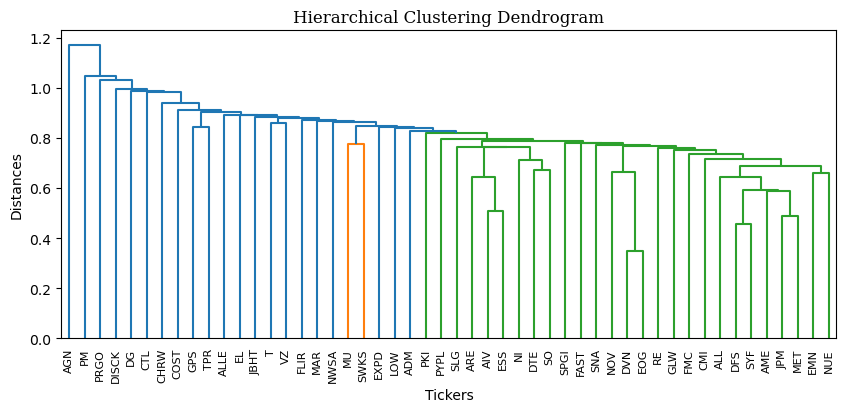

In [15]:
plt.figure(figsize = (10, 4))
hc_single = linkage(squareform(distance_matrix), method = "single")
ddata = dendrogram(hc_single, labels = distance_matrix.index)
plt.xlabel('Tickers')
plt.ylabel('Distances')
plt.title('Hierarchical Clustering Dendrogram', fontsize = 12, fontfamily = 'Serif')
plt.show()

In [16]:
pd.DataFrame(hc_single, 
             columns=['cluster_id_1', 'cluster_id_2', 'distance', 'number of members'],
             index = [ "cluster_{}".format(i+1) for i in range(hc_single.shape[0])])

,cluster_id_1,cluster_id_2,distance,number of members
cluster_1,15.0,18.0,0.346869,2.0
cluster_2,11.0,46.0,0.457362,2.0
cluster_3,27.0,30.0,0.486907,2.0
cluster_4,2.0,19.0,0.509748,2.0
cluster_5,5.0,52.0,0.586114,3.0
cluster_6,51.0,54.0,0.593741,5.0
cluster_7,6.0,53.0,0.642848,3.0
cluster_8,3.0,55.0,0.644946,6.0
cluster_9,17.0,34.0,0.658835,2.0
cluster_10,33.0,50.0,0.662294,3.0


#### Minimum Spinning Trees

In [17]:
pairs =list(itertools.combinations(tickers, 2)) 
edges = []
for a, b in pairs:
    edges.append((distance_matrix.loc[a,b], a, b))

In [18]:
edges.sort()

In [19]:
mst = MinimumSpanningTree(tickers, edges)
tree = mst.build()

The building of tree is completed


In [20]:
tree

[(0.34686860737528546, 'DVN', 'EOG'),
 (0.45736178790682414, 'DFS', 'SYF'),
 (0.48690695701009734, 'JPM', 'MET'),
 (0.5097476163635705, 'AIV', 'ESS'),
 (0.5861135491821758, 'AME', 'MET'),
 (0.5937408992884922, 'JPM', 'SYF'),
 (0.6428480632209314, 'AIV', 'ARE'),
 (0.6449455731797631, 'ALL', 'MET'),
 (0.6588354056569679, 'EMN', 'NUE'),
 (0.6622944074999396, 'DVN', 'NOV'),
 (0.6730573788474931, 'DTE', 'SO'),
 (0.686806406291249, 'MET', 'NUE'),
 (0.7125160525850089, 'DTE', 'NI'),
 (0.7160762289880247, 'CMI', 'EMN'),
 (0.7352999994350058, 'FMC', 'MET'),
 (0.7525698155383778, 'CMI', 'GLW'),
 (0.7586727902020749, 'ALL', 'RE'),
 (0.7623992982242415, 'DTE', 'ESS'),
 (0.7639082518686939, 'ARE', 'SLG'),
 (0.7669288291240546, 'DVN', 'JPM'),
 (0.7706966382766673, 'CMI', 'SNA'),
 (0.7771742479352649, 'MU', 'SWKS'),
 (0.7782604114412074, 'FAST', 'NUE'),
 (0.7808004959763373, 'ALL', 'SPGI'),
 (0.7892516522896503, 'ALL', 'DTE'),
 (0.7973884443760839, 'PYPL', 'SPGI'),
 (0.8179272681821158, 'GLW', 'PKI')

In [21]:
NUM_CLUSTER = 11 # the number of sectors
cluster_info = cut_tree(hc_single, NUM_CLUSTER)
cluster_info = cluster_info.reshape(-1)

In [22]:
G = build_graph(tickers, tree)

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_34845/3846137703.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral_r', NUM_CLUSTER)


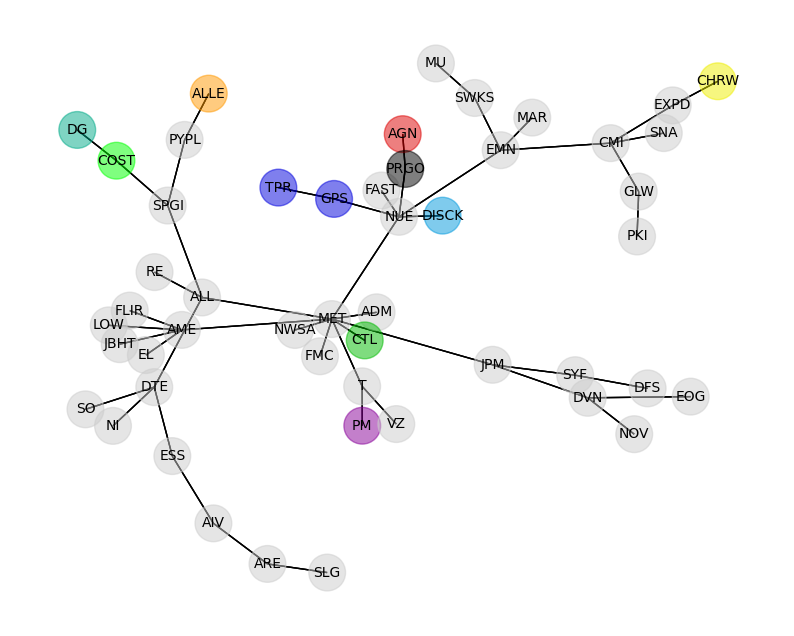

In [31]:
plt.figure(figsize = (10, 8))
cmap = plt.cm.get_cmap('nipy_spectral_r', NUM_CLUSTER)
draw_graph(G, cluster_info, cmap, label = False)

In [27]:
sector_info = []

for ticker in tickers:
    sector = sector_map[ticker]
    sector_num = sector_index[sector]
    sector_info.append(sector_num)

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_34845/898096690.py:3: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


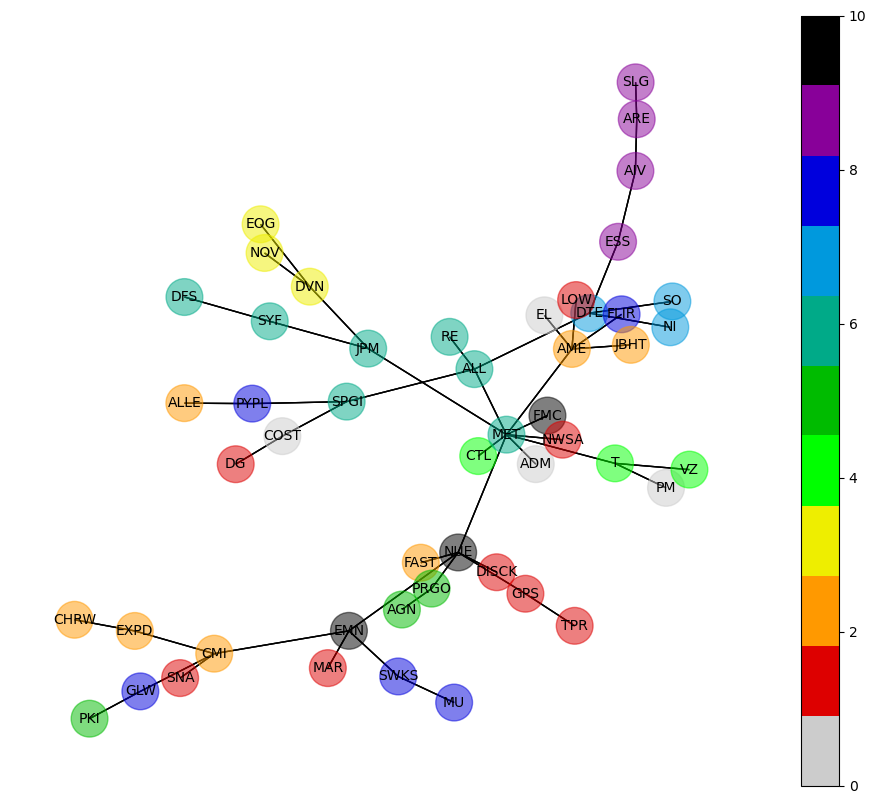

Label:0: Consumer Staples: ADM, COST, EL, PM
Label:1: Consumer Discretionary: DISCK, DG, GPS, LOW, MAR, NWSA, SNA, TPR
Label:2: Industrials: ALLE, AME, CHRW, CMI, EXPD, FAST, JBHT
Label:3: Energy: DVN, EOG, NOV
Label:4: Telecommunication Services: T, CTL, VZ
Label:5: Health Care: AGN, PKI, PRGO
Label:6: Financials: ALL, DFS, RE, JPM, MET, SPGI, SYF
Label:7: Utilities: DTE, NI, SO
Label:8: Information Technology: GLW, FLIR, MU, PYPL, SWKS
Label:9: Real Estate: ARE, AIV, ESS, SLG
Label:10: Materials: EMN, FMC, NUE


In [30]:
plt.figure(figsize = (12, 10))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=NUM_CLUSTER-1))
plt.colorbar(sm)
draw_graph(G, sector_info, cmap, label=False)

for sector_name, index in sector_index.items():
    print(f"Label:{index}: {sector_name}: {', '.join(ticker_info_df[ticker_info_df['Sector']==sector_name]['Symbol'])}")

#### Usecase of MST

In [32]:
def get_distance_in_mst(mst, stock_a, stock_b):
    _, distance = mst.find_path(stock_a, stock_b)
    return distance

def get_filtered_distance_in_mst(mst, stock_a, stock_b):
    if stock_a == stock_b:
        return 0
    else:
        path, _ = mst.find_path(stock_a, stock_b)
        return max([get_distance_in_mst(mst, i, j) for i, j in zip(path, path[1:])])

In [33]:
filtered_ds_matrix = distance_matrix.copy(deep = True)

In [34]:
num_changed = 0
diff_store = []
for stock_a, stock_b in itertools.combinations(distance_matrix.index, 2):
    original_distance = distance_matrix.loc[stock_a, stock_b]
    new_distance = get_filtered_distance_in_mst(mst, stock_a, stock_b)
    if original_distance != new_distance:
        num_changed +=1
        filtered_ds_matrix.loc[stock_a, stock_b] = new_distance
        print(f"Distance of pair: [{stock_a}, {stock_b}] is changed {original_distance:.4f} -> {new_distance:.4f}")
        diff = original_distance - new_distance
        diff_store.append((diff, stock_a, stock_b))

Distance of pair: [ADM, AGN] is changed 1.2579 -> 1.1705
Distance of pair: [ADM, AIV] is changed 1.0906 -> 0.8280
Distance of pair: [ADM, ALL] is changed 0.8811 -> 0.8280
Distance of pair: [ADM, ALLE] is changed 1.0657 -> 0.8921
Distance of pair: [ADM, AME] is changed 0.8740 -> 0.8280
Distance of pair: [ADM, ARE] is changed 1.0728 -> 0.8280
Distance of pair: [ADM, CHRW] is changed 1.1723 -> 0.9390
Distance of pair: [ADM, CMI] is changed 0.9173 -> 0.8280
Distance of pair: [ADM, COST] is changed 1.0709 -> 0.9113
Distance of pair: [ADM, CTL] is changed 1.0851 -> 0.9828
Distance of pair: [ADM, DFS] is changed 0.9190 -> 0.8280
Distance of pair: [ADM, DG] is changed 1.2100 -> 0.9886
Distance of pair: [ADM, DISCK] is changed 1.0530 -> 0.9937
Distance of pair: [ADM, DTE] is changed 1.0199 -> 0.8280
Distance of pair: [ADM, DVN] is changed 0.9558 -> 0.8280
Distance of pair: [ADM, EL] is changed 1.0875 -> 0.8903
Distance of pair: [ADM, EMN] is changed 0.8790 -> 0.8280
Distance of pair: [ADM, EOG]

In [35]:
total_pair = len(list(itertools.combinations(distance_matrix.index, 2)))
print(f"total {num_changed*100/total_pair:2.2f}% distances are changed")

total 96.00% distances are changed


In [36]:
filtered_ds_matrix

,ADM,AGN,AIV,ALL,ALLE,AME,ARE,CHRW,CMI,COST,...,RE,SLG,SNA,SO,SPGI,SWKS,SYF,T,TPR,VZ
ADM,0.000000,1.170525,0.827996,0.827996,0.892054,0.827996,0.827996,0.939029,0.827996,0.911257,...,0.827996,0.827996,0.827996,0.827996,0.827996,0.845789,0.827996,0.880133,0.904135,0.880133
AGN,1.257855,0.000000,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,...,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525
AIV,1.090633,1.312443,0.000000,0.789252,0.892054,0.789252,0.642848,0.939029,0.789252,0.911257,...,0.789252,0.763908,0.789252,0.762399,0.789252,0.845789,0.789252,0.880133,0.904135,0.880133
ALL,0.881133,1.256959,0.940749,0.000000,0.892054,0.644946,0.789252,0.939029,0.716076,0.911257,...,0.758673,0.789252,0.770697,0.789252,0.780800,0.845789,0.644946,0.880133,0.904135,0.880133
ALLE,1.065659,1.248871,1.051387,0.968112,0.000000,0.892054,0.892054,0.939029,0.892054,0.911257,...,0.892054,0.892054,0.892054,0.892054,0.892054,0.892054,0.892054,0.892054,0.904135,0.892054
AME,0.874002,1.203977,1.003287,0.751245,0.894454,0.000000,0.789252,0.939029,0.716076,0.911257,...,0.758673,0.789252,0.770697,0.789252,0.780800,0.845789,0.593741,0.880133,0.904135,0.880133
ARE,1.072785,1.350343,0.642848,0.942061,0.975385,0.922735,0.000000,0.939029,0.789252,0.911257,...,0.789252,0.763908,0.789252,0.762399,0.789252,0.845789,0.789252,0.880133,0.904135,0.880133
CHRW,1.172319,1.327769,1.280850,1.095228,1.239983,1.099735,1.282582,0.000000,0.939029,0.939029,...,0.939029,0.939029,0.939029,0.939029,0.939029,0.939029,0.939029,0.939029,0.939029,0.939029
CMI,0.917307,1.249054,1.179673,0.908749,0.986958,0.787185,1.166411,1.033235,0.000000,0.911257,...,0.758673,0.789252,0.770697,0.789252,0.780800,0.845789,0.716076,0.880133,0.904135,0.880133
COST,1.070947,1.253969,0.984704,0.940098,1.024859,0.958392,1.059959,1.209460,1.059939,0.000000,...,0.911257,0.911257,0.911257,0.911257,0.911257,0.911257,0.911257,0.911257,0.911257,0.911257


#### Clustering based on filtered distance

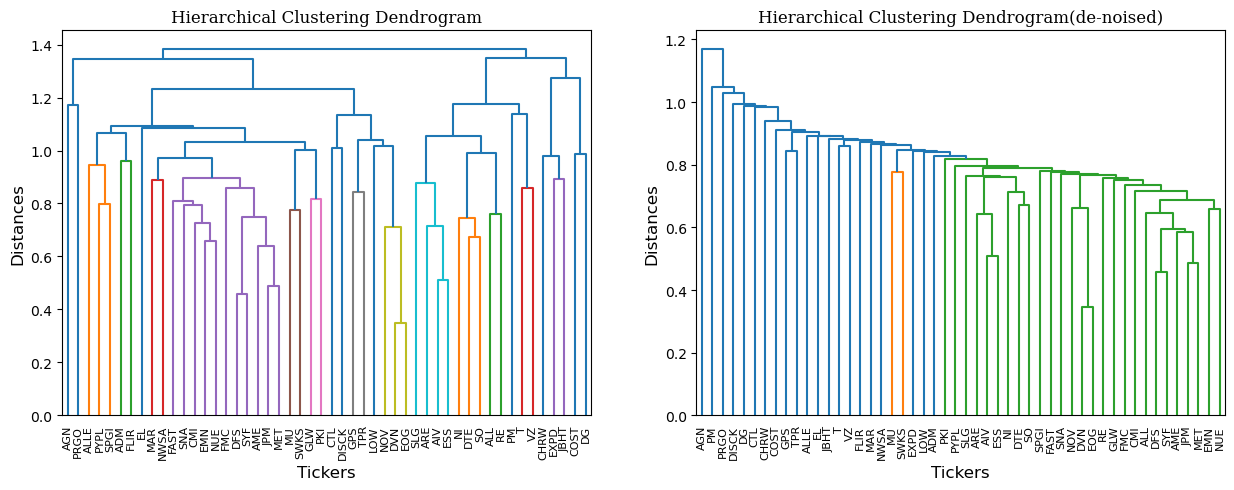

In [39]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
hc_complete = linkage(squareform(distance_matrix), method="complete")
ddata = dendrogram(hc_complete, labels=distance_matrix.index)
plt.xlabel('Tickers', fontsize = 12)
plt.ylabel('Distances', fontsize = 12)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 12, fontfamily = 'Serif')

plt.subplot(122)
new_hc_complete = linkage(get_condensed_distance_matrix(filtered_ds_matrix.to_numpy()), method="complete")
ddata = dendrogram(new_hc_complete, labels=filtered_ds_matrix.index)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Distances', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram(de-noised)', fontsize = 12, fontfamily = 'Serif')
plt.show()

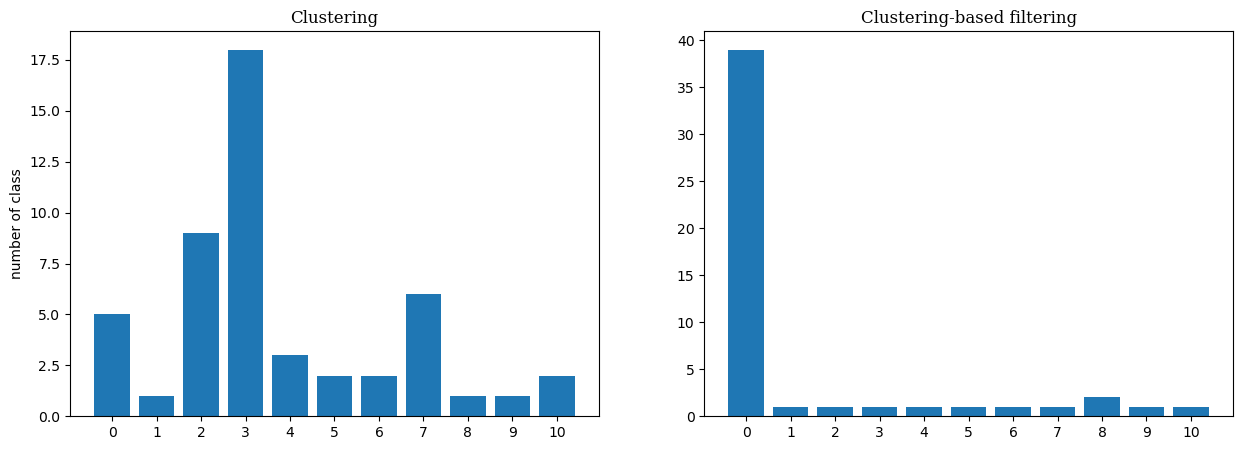

In [41]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.title('Clustering', fontsize = 12, fontfamily = 'Serif')
info = cut_tree(hc_complete, NUM_CLUSTER).reshape(-1)
ni = Counter(info)
nh = list(ni.values())
xpos = np.arange(NUM_CLUSTER)
rects = plt.bar(xpos, nh, align='center')
plt.xticks(xpos)
plt.ylabel('number of class')

plt.subplot(122)
plt.title('Clustering-based filtering', fontsize = 12, fontfamily = 'Serif')
info = cut_tree(new_hc_complete, NUM_CLUSTER).reshape(-1)
ni = Counter(info)
nh = list(ni.values())
xpos = np.arange(NUM_CLUSTER)
rects = plt.bar(xpos, nh, align='center')
plt.xticks(xpos)
plt.show()

아래와 같이 많은 쌍의 거리가 상당히 감소하고 거리의 분산이 감소하는 것으로 나타났기 때문에 이를 상관관계 변화의 관점에서 사용할 수 있다

일반적으로 주식 데이터는 신호 대 잡음비가 낮은 것으로 알려져 있기 때문에 이 방법이 포트폴리오 최적화에 도움이 될 수 있다

#### Korean Stock Data

In [52]:
stock_list = pd.read_csv('../../Data/stock_list.csv', index_col = 0)
stock_list = stock_list[stock_list.Code.str.endswith('0')]
stock_list

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,NaN,71300,2,-400,-0.56,71100,71400,70800,6988218,497101486200,425645495815000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,NaN,557000,2,-3000,-0.54,560000,563000,551000,251421,140379001000,130338000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,NaN,116700,2,-800,-0.68,116500,117300,115200,1352313,157092787800,84957875995500,728002365,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,NaN,734000,2,-7000,-0.94,739000,743000,730000,24105,17787925000,52241716000000,71174000,STK
5,051910,KR7051910008,LG화학,KOSPI,NaN,688000,1,1000,0.15,687000,704000,684000,233869,162373057000,48567531984000,70592343,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,288490,KR7288490006,나라소프트,KONEX,일반기업부,70,1,7,11.11,57,72,57,450742,30987351,2670290000,38147000,KNX
2727,245450,KR7245450002,씨앤에스링크,KONEX,일반기업부,1598,3,0,0.00,1598,1598,1598,1,1598,2524776080,1579960,KNX
2728,322190,KR7322190000,베른,KONEX,일반기업부,140,1,6,4.48,152,152,116,8,1168,1249527580,8925197,KNX
2729,308700,KR7308700004,테크엔,KONEX,일반기업부,241,4,31,14.76,241,241,241,25,6025,964000000,4000000,KNX


In [53]:
stock_list.Code[:500]

0      005930
1      373220
2      000660
3      207940
5      051910
        ...  
503    089980
504    352480
505    005180
506    145990
507    034310
Name: Code, Length: 500, dtype: object

In [54]:
import pandas_datareader.data as web

data = pd.DataFrame()
for code in stock_list.Code[:500] : 
    data = pd.concat([data,web.DataReader(code, 'naver', start = '2020-01-01', end = '2023-09-30')['Close'].apply(int)], axis = 1)
data.columns = stock_list.Name[:500]

In [57]:
data = data.dropna(axis = 1)

In [59]:
log_ret = compute_log_returns(data)

In [60]:
correlation_matrix = log_ret.corr()
distance_matrix = convert_to_distance_matrix(correlation_matrix)

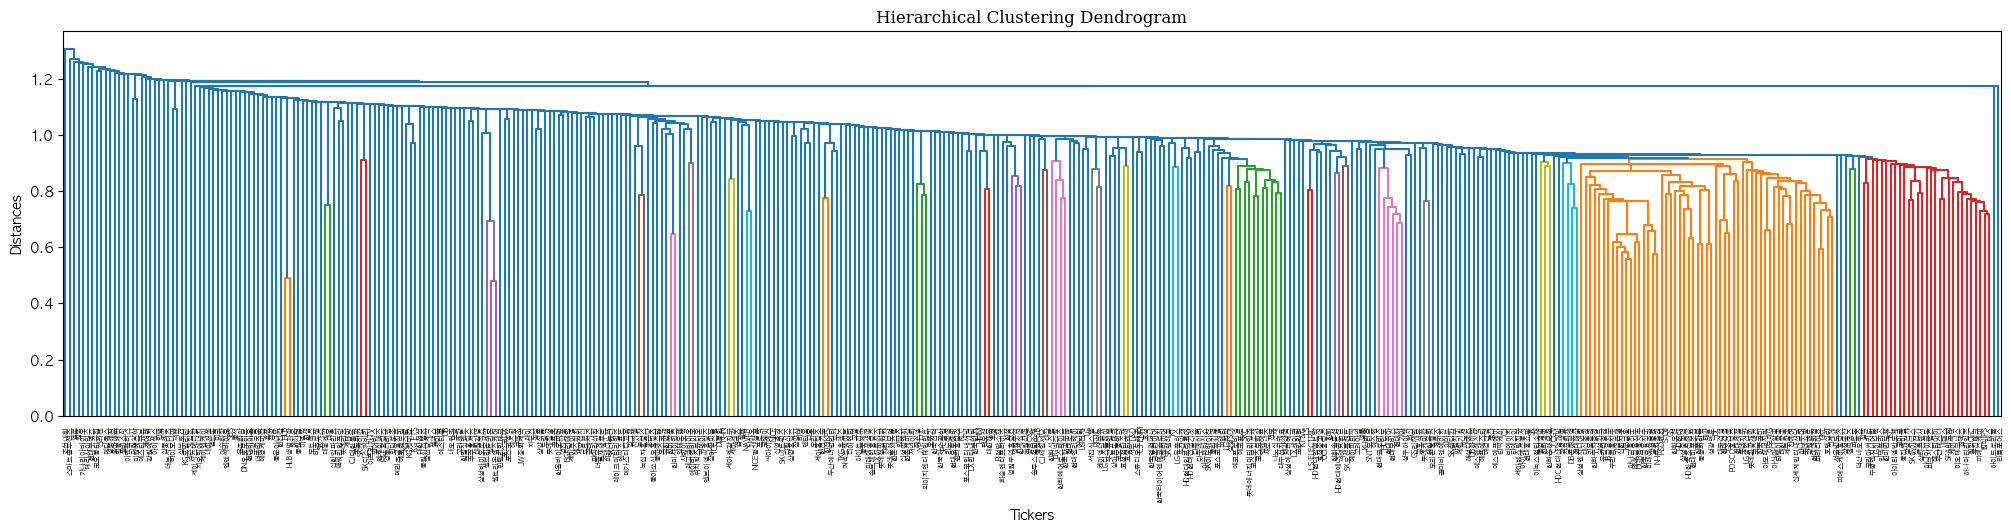

In [69]:
from matplotlib import font_manager, rc
plt.figure(figsize = (25, 5))
rc('font', family = 'AppleGothic')
hc_single = linkage(squareform(distance_matrix), method = "single")
ddata = dendrogram(hc_single, labels = distance_matrix.index)
plt.rcdefaults()
plt.xlabel('Tickers')
plt.ylabel('Distances')
plt.title('Hierarchical Clustering Dendrogram', fontsize = 12, fontfamily = 'Serif')
plt.show()

In [72]:
pd.DataFrame(hc_single, 
             columns=['cluster_id_1', 'cluster_id_2', 'distance', 'number of members'],
             index = [ "cluster_{}".format(i+1) for i in range(hc_single.shape[0])])

,cluster_id_1,cluster_id_2,distance,number of members
cluster_1,14.0,29.0,0.480417,2.0
cluster_2,75.0,229.0,0.491709,2.0
cluster_3,16.0,23.0,0.557940,2.0
cluster_4,89.0,90.0,0.575469,2.0
cluster_5,18.0,434.0,0.584408,3.0
...,...,...,...,...
cluster_427,220.0,857.0,1.252166,428.0
cluster_428,244.0,858.0,1.255372,429.0
cluster_429,231.0,859.0,1.257856,430.0
cluster_430,352.0,860.0,1.271243,431.0


#### MST

In [79]:
data.columns

Index(['삼성전자', 'SK하이닉스', '삼성바이오로직스', 'LG화학', '삼성SDI', '현대차', 'POSCO홀딩스',
       '포스코퓨처엠', '에코프로비엠', '기아',
       ...
       '에스티아이', '에이피티씨', '세아제강', '제이브이엠', '동성화인텍', 'HD현대에너지솔루션', '상아프론테크',
       '빙그레', '삼양사', 'NICE'],
      dtype='object', name='Name', length=432)

In [80]:
tickers = list(data.columns)

In [81]:
pairs = list(itertools.combinations(tickers, 2)) 
edges = []
for a, b in pairs:
    edges.append((distance_matrix.loc[a,b], a, b))

In [82]:
edges.sort()

mst = MinimumSpanningTree(tickers, edges)
tree = mst.build()

The building of tree is completed


In [83]:
tree

[(0.48041660746088394, '셀트리온', '셀트리온헬스케어'),
 (0.4917087075755372, 'HLB', 'HLB생명과학'),
 (0.5579404694915433, 'KB금융', '하나금융지주'),
 (0.5754689021615782, '삼성증권', 'NH투자증권'),
 (0.5844084026532039, '신한지주', '하나금융지주'),
 (0.5944419605525477, '파라다이스', 'GKL'),
 (0.6017155828115922, '신한지주', '기업은행'),
 (0.6108211620036638, '한국카본', '동성화인텍'),
 (0.6109676828754804, '태광', '성광벤드'),
 (0.6180215115261825, '우리금융지주', '기업은행'),
 (0.6201028825848138, 'BNK금융지주', 'DGB금융지주'),
 (0.6308645042450881, 'HD한국조선해양', '현대미포조선'),
 (0.6457400982874413, '기업은행', 'BNK금융지주'),
 (0.64788354970395, '한미약품', '한미사이언스'),
 (0.6501042743952669, '현대건설', 'GS건설'),
 (0.6579474648268829, '미래에셋증권', '삼성증권'),
 (0.6600714551605066, '아모레퍼시픽', '아모레G'),
 (0.6775408438352544, '삼성증권', '한국금융지주'),
 (0.6808964008257699, '제주항공', '진에어'),
 (0.6843236671055279, '현대차', '기아'),
 (0.6933847828057044, '셀트리온헬스케어', '셀트리온제약'),
 (0.6961423242268238, '대우건설', 'GS건설'),
 (0.7070640012200438, '호텔신라', '신세계'),
 (0.7165786180398312, '현대차', '현대모비스'),
 (0.7189868849881611, '원익IPS

In [101]:
NUM_CLUSTER = 20 # the number of sectors
cluster_info = cut_tree(hc_single, NUM_CLUSTER)
cluster_info = cluster_info.reshape(-1)

In [102]:
G = build_graph(tickers, tree)

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_34845/3241812441.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral_r', NUM_CLUSTER)


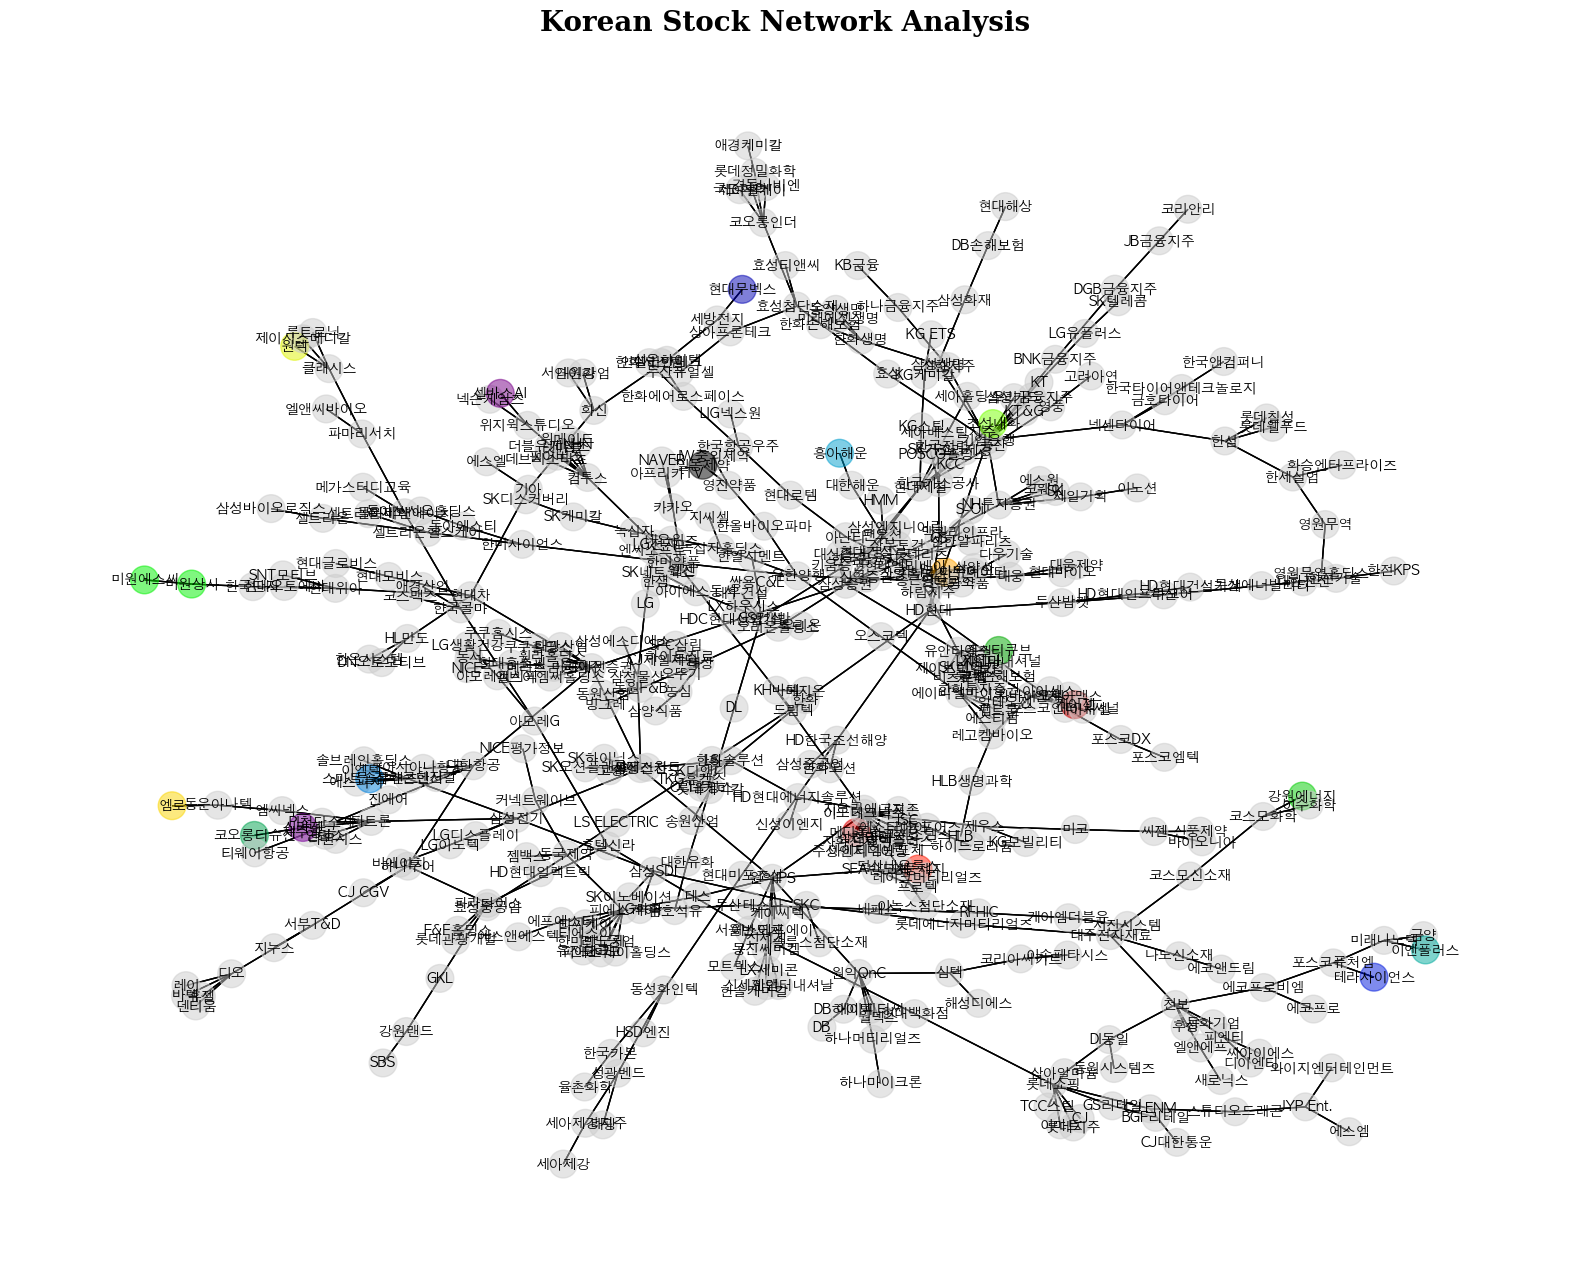

In [103]:
def draw_graph_k(graph, color_index, cmap, label=True):
    pos = nx.spring_layout(graph)
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_edges(graph, pos, width=1)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_family='AppleGothic')
    labels = nx.get_edge_attributes(graph, 'weight')
    if label:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    nx.draw(graph, pos, node_color=color_index, cmap=cmap, node_size=400, alpha=0.5)
    plt.show()

plt.figure(figsize = (20, 16))
plt.rcdefaults()
cmap = plt.cm.get_cmap('nipy_spectral_r', NUM_CLUSTER)
plt.title('Korean Stock Network Analysis', fontfamily = 'Serif', fontsize = 20, fontweight = 'bold')
draw_graph_k(G, cluster_info, cmap, label = False)

In [106]:
filtered_ds_matrix = distance_matrix.copy(deep = True)

In [108]:
num_changed = 0
diff_store = []
for stock_a, stock_b in itertools.combinations(distance_matrix.index, 2):
    original_distance = distance_matrix.loc[stock_a, stock_b]
    new_distance = get_filtered_distance_in_mst(mst, stock_a, stock_b)
    if original_distance != new_distance:
        num_changed +=1
        filtered_ds_matrix.loc[stock_a, stock_b] = new_distance
        #print(f"Distance of pair: [{stock_a}, {stock_b}] is changed {original_distance:.4f} -> {new_distance:.4f}")
        diff = original_distance - new_distance
        diff_store.append((diff, stock_a, stock_b))

In [109]:
total_pair = len(list(itertools.combinations(distance_matrix.index, 2)))
print(f"total {num_changed*100/total_pair:2.2f}% distances are changed")

total 99.54% distances are changed


In [110]:
filtered_ds_matrix

Name,삼성전자,SK하이닉스,삼성바이오로직스,LG화학,삼성SDI,현대차,POSCO홀딩스,포스코퓨처엠,에코프로비엠,기아,...,에스티아이,에이피티씨,세아제강,제이브이엠,동성화인텍,HD현대에너지솔루션,상아프론테크,빙그레,삼양사,NICE
Name,,,,,,,,,,,,,,,,,,,,,
삼성전자,0.000000,0.769571,1.092655,0.983773,0.983773,0.971925,0.928180,0.983773,0.983773,0.971925,...,0.883827,0.976094,1.053935,1.079106,0.928180,0.976611,0.992001,1.068342,1.044645,1.047207
SK하이닉스,0.769571,0.000000,1.092655,0.983773,0.983773,0.971925,0.928180,0.983773,0.983773,0.971925,...,0.883827,0.976094,1.053935,1.079106,0.928180,0.976611,0.992001,1.068342,1.044645,1.047207
삼성바이오로직스,1.190675,1.233842,0.000000,1.092655,1.092655,1.092655,1.092655,1.092655,1.092655,1.092655,...,1.092655,1.092655,1.092655,1.092655,1.092655,1.092655,1.092655,1.092655,1.092655,1.092655
LG화학,1.119551,1.182562,1.180202,0.000000,0.818500,0.983773,0.983773,0.933550,0.913651,0.983773,...,0.983773,0.983773,1.053935,1.079106,0.983773,0.983773,0.992001,1.068342,1.044645,1.047207
삼성SDI,1.077480,1.148260,1.101271,0.818500,0.000000,0.983773,0.983773,0.933550,0.913651,0.983773,...,0.983773,0.983773,1.053935,1.079106,0.983773,0.983773,0.992001,1.068342,1.044645,1.047207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HD현대에너지솔루션,1.220791,1.250390,1.248182,1.167706,1.123685,1.204969,1.243411,1.173515,1.224654,1.235716,...,1.183078,1.205359,1.177401,1.220009,1.056229,0.000000,0.992001,1.068342,1.044645,1.047207
상아프론테크,1.139149,1.219827,1.167546,1.103890,1.040574,1.157554,1.250717,1.087235,1.110615,1.159829,...,1.064886,1.102907,1.193516,1.142083,1.082575,1.089419,0.000000,1.068342,1.044645,1.047207
빙그레,1.273133,1.303873,1.316647,1.295406,1.287931,1.243771,1.272594,1.280522,1.314626,1.255633,...,1.227704,1.255800,1.253210,1.207135,1.180960,1.291235,1.223767,0.000000,1.068342,1.068342


<Axes: xlabel='Name', ylabel='Name'>

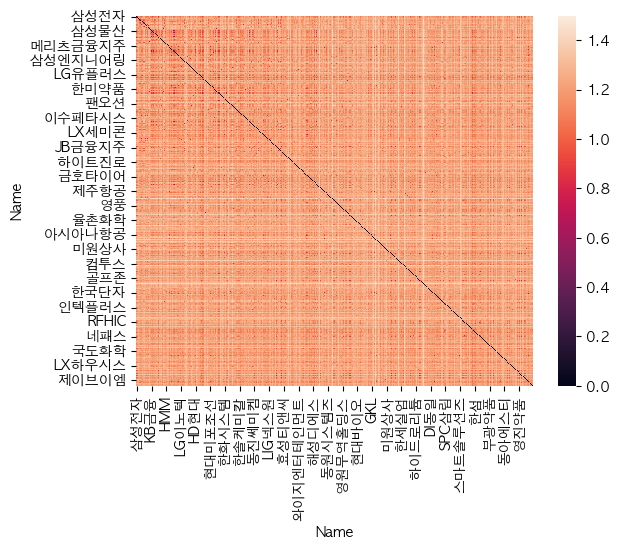

In [114]:
import seaborn as sns
rc('font', family = 'AppleGothic')
sns.heatmap(distance_matrix)

<Axes: xlabel='Name', ylabel='Name'>

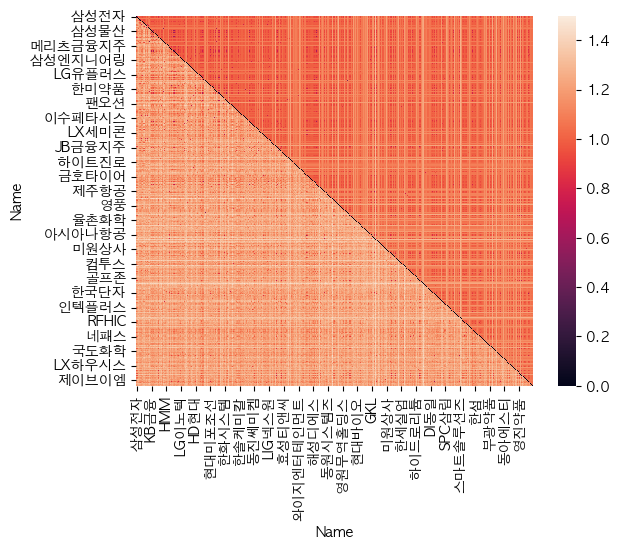

In [112]:
sns.heatmap(filtered_ds_matrix)

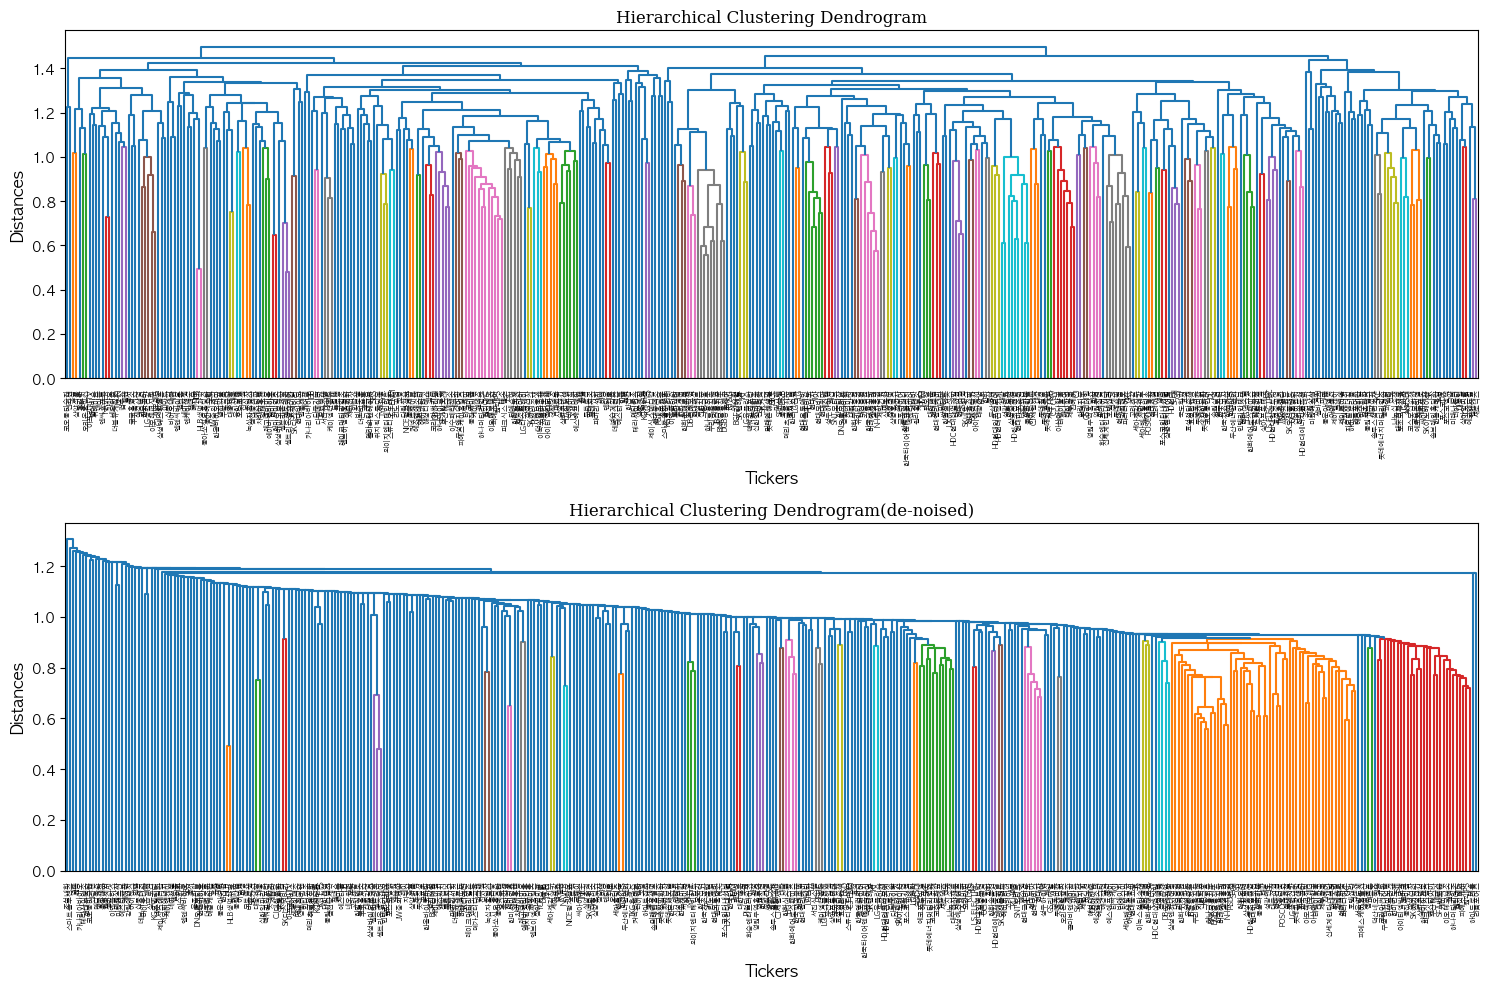

In [124]:
plt.figure(figsize = (15, 10))

plt.subplot(211)
hc_complete = linkage(squareform(distance_matrix), method="complete")
ddata = dendrogram(hc_complete, labels=distance_matrix.index)
plt.xlabel('Tickers', fontsize = 12)
plt.ylabel('Distances', fontsize = 12)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 12, fontfamily = 'Serif')

plt.subplot(212)
new_hc_complete = linkage(get_condensed_distance_matrix(filtered_ds_matrix.to_numpy()), method="complete")
ddata = dendrogram(new_hc_complete, labels=filtered_ds_matrix.index)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Distances', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram(de-noised)', fontsize = 12, fontfamily = 'Serif')
plt.tight_layout()
plt.show()

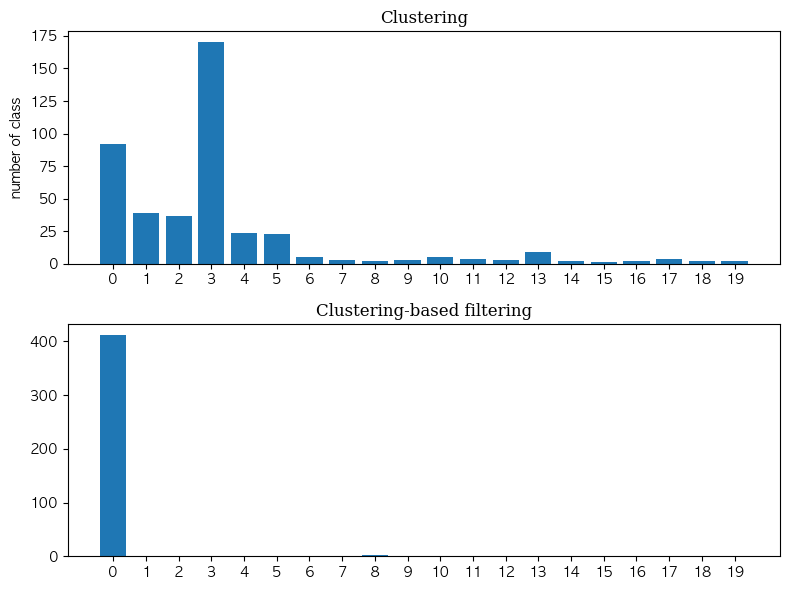

In [128]:
plt.figure(figsize = (8, 6))
plt.subplot(211)
plt.title('Clustering', fontsize = 12, fontfamily = 'Serif')
info = cut_tree(hc_complete, NUM_CLUSTER).reshape(-1)
ni = Counter(info)
nh = list(ni.values())
xpos = np.arange(NUM_CLUSTER)
rects = plt.bar(xpos, nh, align='center')
plt.xticks(xpos)
plt.ylabel('number of class')

plt.subplot(212)
plt.title('Clustering-based filtering', fontsize = 12, fontfamily = 'Serif')
info = cut_tree(new_hc_complete, NUM_CLUSTER).reshape(-1)
ni = Counter(info)
nh = list(ni.values())
xpos = np.arange(NUM_CLUSTER)
rects = plt.bar(xpos, nh, align='center')
plt.xticks(xpos)
plt.tight_layout()
plt.show()